# Titanic Survival Classification

In [1]:
import pandas as pd
import numpy as np
titanic = pd.read_csv("C:\\Users\\nicol\\Titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#Drop passenger ID, name, ticket # and cabin (687 missing values)
def preprocessing (titanic):

    titanic.drop(axis = 1, columns = ['PassengerId','Ticket','Cabin'], inplace = True) 
    
    #Converting embarkation to integer and filling nans with most common instance.
    emb_dict = {'S' :0, 'C' :1, 'Q': 2}
    titanic['Embarked'] = titanic['Embarked'].map(emb_dict, 'ignore')
    titanic['Embarked'] = titanic['Embarked'].fillna(titanic['Embarked'].mode().iloc[0])
    
    #data imputation for age NaNs
    min = titanic['Age'].mean() - titanic['Age'].std()
    max = titanic['Age'].mean() + titanic['Age'].std()
    null_age = list(np.random.randint(min, max, size = 1))

    titanic.loc[titanic['Age'].isnull(), 'Age'] = null_age
    titanic['Age'] = titanic['Age'].astype(int)
    titanic['Fare'] = titanic['Fare'].astype(int)
    
    titanic[['Name']].applymap(lambda x:x.replace("Mlle","Miss"))
    titanic[['Name']].applymap(lambda x:x.replace("Ms","Miss"))
    titanic[['Name']].applymap(lambda x:x.replace("Mme","Mrs"))
    
    titanic['Name'] = titanic['Name'].apply(lambda x: '1' if 'Mr. ' in x else x)
    titanic['Name'] = titanic['Name'].apply(lambda x: '2' if 'Miss' in x else x)
    titanic['Name'] = titanic['Name'].apply(lambda x: '3' if 'Mrs. ' in x else x)
    titanic['Name'] = titanic['Name'].apply(lambda x: '4' if 'Master' in x else x)
    titanic['Name'] = titanic['Name'].apply(lambda x: '5' if 'Rare' in x else x)
    
    titanic['Name'] = titanic['Name'].apply(lambda x: '0' if len(x) > 1 else x)
    titanic['Name'] = titanic['Name'].astype(int)
    
    return titanic

new_titanic = preprocessing(titanic)
new_titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,male,22,1,0,7,0.0
1,1,1,3,female,38,1,0,71,1.0
2,1,3,2,female,26,0,0,7,0.0
3,1,1,3,female,35,1,0,53,0.0
4,0,3,1,male,35,0,0,8,0.0


In [3]:
from sklearn.preprocessing import LabelEncoder

# 1= male, 0 = female
titanic_clean = new_titanic.copy() 
labelencoder = LabelEncoder()
titanic_clean['Sex'] = labelencoder.fit_transform(titanic_clean['Sex'])
titanic_clean.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,1,22,1,0,7,0.0
1,1,1,3,0,38,1,0,71,1.0
2,1,3,2,0,26,0,0,7,0.0
3,1,1,3,0,35,1,0,53,0.0
4,0,3,1,1,35,0,0,8,0.0


In [4]:
from sklearn.preprocessing import MinMaxScaler

#using minmaxscaler to normalize data values (in comparison to standardization/StandardScaler)
#default values are between 0-1. a preferred scale can be specified via the “feature_range” 
#argument and specify a tuple, including the min and the max for all variables.
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(titanic_clean) 
titanic_clean.loc[:,:] = scaled_values
titanic_clean.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,1.0,0.25,1.0,0.2750,0.125,0.0,0.013672,0.0
1,1.0,0.0,0.75,0.0,0.4750,0.125,0.0,0.138672,0.5
2,1.0,1.0,0.50,0.0,0.3250,0.000,0.0,0.013672,0.0
3,1.0,0.0,0.75,0.0,0.4375,0.125,0.0,0.103516,0.0
4,0.0,1.0,0.25,1.0,0.4375,0.000,0.0,0.015625,0.0


In [5]:
#pulling out the survived (outcome) column and making it its own dataframe
response = pd.DataFrame(titanic_clean['Survived'])
#selecting the remaining columns and creating a predictors dataframe
features = titanic_clean.iloc[:,1:9]

In [6]:
features.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,0.25,1.0,0.2750,0.125,0.0,0.013672,0.0
1,0.0,0.75,0.0,0.4750,0.125,0.0,0.138672,0.5
2,1.0,0.50,0.0,0.3250,0.000,0.0,0.013672,0.0
3,0.0,0.75,0.0,0.4375,0.125,0.0,0.103516,0.0
4,1.0,0.25,1.0,0.4375,0.000,0.0,0.015625,0.0


In [7]:
from sklearn.model_selection import train_test_split

#using sklearn to divide the data into train and test sets. 
#train_test_split (predictor DF, response DF, test_size (usually 20%), random_state=0 
#non random generation)
my_result_list = train_test_split(features, response, test_size=0.20, random_state=0)
features_train, features_test, response_train, response_test = my_result_list

In [8]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state = 0) #defining the classifier
classifier.fit(features_train, response_train)#fitting the decision tree model to our data

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [9]:
#using the defined classifier to generate predictions
response_pred = classifier.predict(features_test)
print('Predictions', response_pred)
print('Actuals ',list(response_test['Survived']))

Predictions [0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
Actuals  [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

Model One

In [47]:
models_list = [RandomForestClassifier(),
               DecisionTreeClassifier(),
               XGBClassifier()]
model_names = ['Random Forest', 
               'Decision Tree',
               'Extreme Gradient Boosting']

accuracy_list = []
results_dict = {}

for model in range(len(models_list)):
    classifier = models_list[model]
    classifier.fit(features_train, response_train)
    new_response_pred = classifier.predict(features_test)
    accuracy_list.append(accuracy_score(response_pred,response_test))
    
results_dict = {'Model Name': model_names, 'Accuracy': accuracy_list}
results_df = pd.DataFrame(results_dict)
results_df.head()

C:\Users\nicol\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Model Name,Accuracy
0,Random Forest,0.810056
1,Decision Tree,0.810056
2,Extreme Gradient Boosting,0.810056


In [10]:
from sklearn.metrics import accuracy_score
print('Accuracy Score for decision tree model:', accuracy_score(y_true=response_test, y_pred=response_pred))

Accuracy Score for decision tree model: 0.8100558659217877


In [11]:
#creating importance variable and developing a list for importance dataframe.
importance = classifier.feature_importances_
feature_names = features.columns.to_list()

In [12]:
#creating dataframe for feature names and corresponding importance.
#creating dataframe with the feature names list as the only column.
df_importance = pd.DataFrame(feature_names, columns = ['Feature Name'])

#creating an additional column with the corresponding importance score under the name 'score'
df_importance['Score'] = importance
df_importance

,Feature Name,Score
0,Pclass,0.131111
1,Name,0.367273
2,Sex,0.023540
3,Age,0.183608
4,SibSp,0.023743
5,Parch,0.038507
6,Fare,0.202927
7,Embarked,0.029290


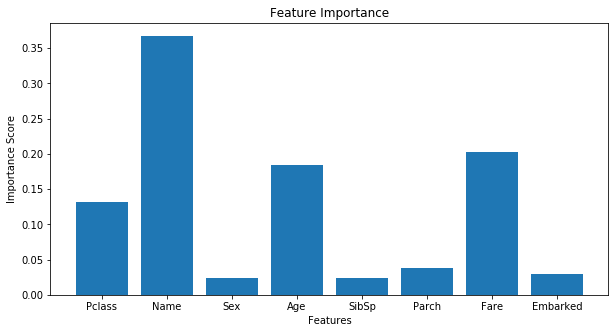

In [13]:
from matplotlib import pyplot
pyplot.figure(figsize=(10, 5))

pyplot.bar(x = list(range(len(importance))), height = importance, tick_label = feature_names)
pyplot.title('Feature Importance')
pyplot.xlabel('Features')
pyplot.ylabel('Importance Score')
pyplot.show()

Model Two <br/>
-->Dropping features to increase model accuracy

In [40]:
#creating new features dataframe dropping the lowest loading (sex) and third lowest (embarked). 
#dropping the second lowest (sibsp) resulted in a lower accuracy 
new_response = response
new_features = features.drop(axis=1, columns = ['Sex', 'Embarked'])

In [41]:
from sklearn.model_selection import train_test_split
my_new_result_list = train_test_split(new_features, new_response, test_size=0.20, random_state=0)
new_features_train, new_features_test, new_response_train, new_response_test = my_new_result_list

In [42]:
classifier.fit(new_features_train, new_response_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [43]:
new_response_pred = classifier.predict(new_features_test)
print('Predictions', new_response_pred)
print('Actuals ',list(new_response_test['Survived']))

Predictions [0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
Actuals  [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.

In [44]:
print('Accuracy Score for decision tree model:', accuracy_score(y_true=new_response_test, y_pred=new_response_pred))

Accuracy Score for decision tree model: 0.8268156424581006


In [49]:
models_list = [RandomForestClassifier(),
               DecisionTreeClassifier(),
               XGBClassifier()]
model_names = ['Random Forest', 
               'Decision Tree',
               'Extreme Gradient Boosting']

accuracy_list = []
results_dict = {}

for model in range(len(models_list)):
    classifier = models_list[model]
    classifier.fit(new_features_train, new_response_train)
    new_response_pred = classifier.predict(new_features_test)
    accuracy_list.append(accuracy_score(new_response_pred, new_response_test))
    
results_dict = {'Model Name': model_names, 'Accuracy': accuracy_list}
results_df = pd.DataFrame(results_dict)
results_df.head()

C:\Users\nicol\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Model Name,Accuracy
0,Random Forest,0.826816
1,Decision Tree,0.826816
2,Extreme Gradient Boosting,0.871508


Evaluating feature importance of new, improved model

In [30]:
#creating importance variable and developing a list for importance dataframe.
new_importance = classifier.feature_importances_
new_feature_names = new_features.columns.to_list()

In [31]:
#creating dataframe for feature names and corresponding importance.
#creating dataframe with the feature names list as the only column and adding new score column.
new_df_importance = pd.DataFrame(new_feature_names, columns = ['Feature Name'])
new_df_importance['Score'] = new_importance
new_df_importance

,Feature Name,Score
0,Pclass,0.132837
1,Name,0.368940
2,Age,0.206681
3,SibSp,0.023482
4,Parch,0.024823
5,Fare,0.243236


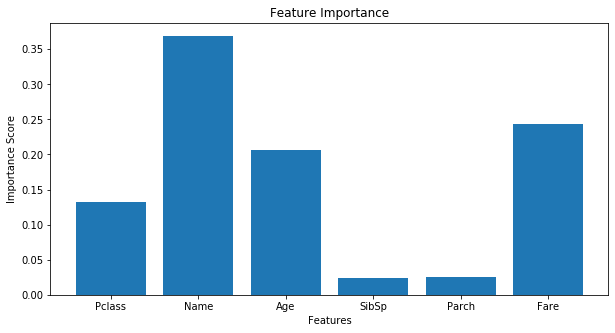

In [34]:
from matplotlib import pyplot
pyplot.figure(figsize=(10, 5))

pyplot.bar(x = list(range(len(new_importance))), height = new_importance, tick_label = new_feature_names)
pyplot.title('Feature Importance')
pyplot.xlabel('Features')
pyplot.ylabel('Importance Score')
pyplot.show()